In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (log_loss, brier_score_loss, roc_auc_score, accuracy_score)
import optuna

C:\Users\leonc\AppData\Roaming\Python\Python314\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Expected Calibration Error (ECE): Good way of measuring probability calibration (check readme for betetr description)
def expected_calibration_error(y_out, y_prob, n_bins=10, return_bins=False):
    y_out = np.asarray(y_out).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    m = ~np.isnan(y_prob)
    y_out = y_out[m]
    y_prob = y_prob[m]
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(y_prob, bin_edges, right=True) - 1
    bin_ids = np.clip(bin_ids, 0, n_bins - 1)
    acc = np.full(n_bins, np.nan)
    conf = np.full(n_bins, np.nan)
    counts = np.zeros(n_bins, dtype=int)
    n = len(y_out)
    ece = 0.0

    for b in range(n_bins):
        idx = bin_ids == b
        counts[b] = idx.sum()
        if counts[b] > 0:
            acc[b] = y_out[idx].mean()
            conf[b] = y_prob[idx].mean()
            ece += (counts[b] / n) * abs(acc[b] - conf[b])
    if return_bins:
        return ece, acc, conf, counts, bin_edges
    return ece

#Plot reliability diagram and a probability histogram 
def reliability_diagram(y_out,y_prob,n_bins=10,hist_bins=30,title="Reliability Diagram"):
    
    ece, acc, conf, counts, bin_edges = expected_calibration_error(y_out, y_prob, n_bins=n_bins, return_bins=True)
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    width = (bin_edges[1] - bin_edges[0]) * 0.9
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 7),gridspec_kw={"height_ratios": [3, 2]})

    #reliability diagram
    ax1.plot([0, 1], [0, 1], linestyle="--", linewidth=2, label="Perfect calibration")
    ax1.bar(centers, np.nan_to_num(acc, nan=0.0), width=width, label="Accuracy")
    bottom = np.nan_to_num(np.minimum(acc, conf), nan=0.0)
    height = np.nan_to_num(np.abs(acc - conf), nan=0.0)
    ax1.bar(centers, height, bottom=bottom, width=width, hatch="xx", alpha=0.35,color="tab:red", label="Gap")
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.set_xlabel("Confidence")
    ax1.set_ylabel("Accuracy")
    ax1.set_title(title)

    # Display ECE in percentage points
    ax1.text(0.62, 0.06, f"ECE={ece*100:.2f}",
        transform=ax1.transAxes,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.85))
    ax1.legend(loc="upper left")

    #probability histogram 
    ax2.hist(y_prob, bins=hist_bins)
    ax2.set_xlim(0, 1)
    ax2.set_xlabel("Predicted probability")
    ax2.set_ylabel("Count")
    ax2.set_title("Predicted probability distribution")
    plt.tight_layout()
    plt.show()

    return ece

In [3]:
data = pd.read_csv("Final/train.csv")

X = data.drop(columns=["result"]).values
y = data["result"].astype(int).values

X = np.asarray(X)
y = np.asarray(y).astype(int)


def ts_cv_oof_probs(params, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    oof = np.full(len(y), np.nan, dtype=float)

    for train_idx, test_idx in tscv.split(X):
        model = XGBClassifier(
            **params,
            objective="binary:logistic",
            eval_metric="logloss",
            tree_method="hist",
            random_state=42,
            n_jobs=-1
        )
        model.fit(X[train_idx], y[train_idx])
        oof[test_idx] = model.predict_proba(X[test_idx])[:, 1]

    return oof

def ts_cv_logloss(params, n_splits=5):
    oof = ts_cv_oof_probs(params, n_splits)
    m = ~np.isnan(oof)
    return log_loss(y[m], oof[m])

def ts_cv_error_rate(params, n_splits=5):
    oof = ts_cv_oof_probs(params, n_splits)
    m = ~np.isnan(oof)
    preds = (oof[m] >= 0.5).astype(int)
    return 1.0 - accuracy_score(y[m], preds)




In [4]:
# LOG-LOSS OPTIMIZATION

def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 2, 8),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 10.0),
        "n_estimators": trial.suggest_int("n_estimators", 300, 1500),
    }

    ll = ts_cv_logloss(params, n_splits=3)
    return ll

study1 = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study1.optimize(objective, n_trials=50) 

print("Best params:", study1.best_params)
print("Best CV log loss:", study1.best_value)


[I 2026-01-19 16:52:26,790] A new study created in memory with name: no-name-7e6fc958-8949-47e7-b0da-35e550302d52
[I 2026-01-19 16:52:35,221] Trial 0 finished with value: 0.6464839868769465 and parameters: {'max_depth': 4, 'learning_rate': 0.22648248189516848, 'subsample': 0.892797576724562, 'colsample_bytree': 0.8394633936788146, 'min_child_weight': 2.4041677639819286, 'n_estimators': 487}. Best is trial 0 with value: 0.6464839868769465.
[I 2026-01-19 16:52:51,178] Trial 1 finished with value: 0.6100227089899385 and parameters: {'max_depth': 2, 'learning_rate': 0.13983740016490973, 'subsample': 0.8404460046972835, 'colsample_bytree': 0.8832290311184181, 'min_child_weight': 1.185260448662222, 'n_estimators': 1464}. Best is trial 1 with value: 0.6100227089899385.
[I 2026-01-19 16:53:37,160] Trial 2 finished with value: 0.5927527851952331 and parameters: {'max_depth': 7, 'learning_rate': 0.0033572967053517922, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'min_

Best params: {'max_depth': 4, 'learning_rate': 0.0072712729339508, 'subsample': 0.6890395724443819, 'colsample_bytree': 0.7688217801997627, 'min_child_weight': 4.637518788125464, 'n_estimators': 1030}
Best CV log loss: 0.5913387520168244


OOF log loss: 0.5919759718738125
OOF accuracy: 0.6785579106737321
OOF error rate: 0.32144208932626794
OOF ECE: 0.006672269820160219
OOF ECE (% points): 0.6672269820160219


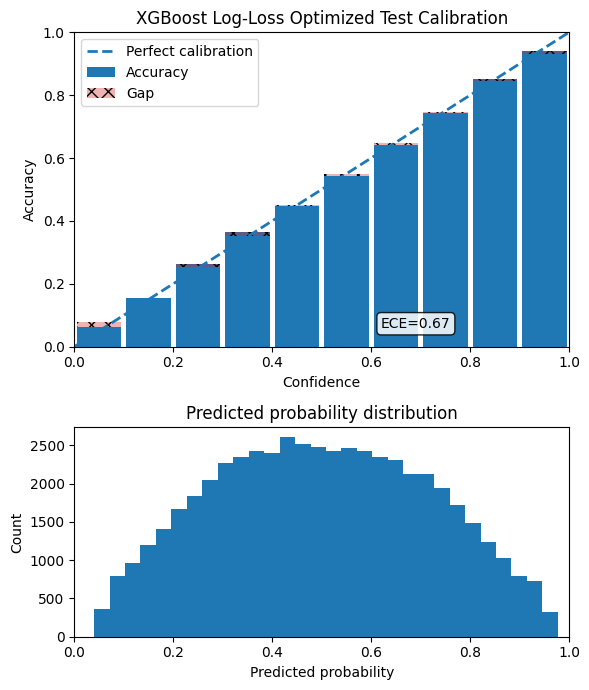

In [5]:

best_params1 = study1.best_params
oof_probs1 = ts_cv_oof_probs(best_params1, n_splits=10)

m = ~np.isnan(oof_probs1)
oof_logloss = log_loss(y[m], oof_probs1[m])
oof_acc = accuracy_score(y[m], (oof_probs1[m] >= 0.5).astype(int))
oof_error_rate = 1.0 - oof_acc
ece = expected_calibration_error(y, oof_probs1, n_bins=10)

print(f"OOF log loss: {oof_logloss}")
print(f"OOF accuracy: {oof_acc}")
print(f"OOF error rate: {oof_error_rate}")
print(f"OOF ECE: {ece}")
print(f"OOF ECE (% points): {ece*100}")

figurea = reliability_diagram(y, oof_probs1, n_bins=10, title="XGBoost Log-Loss Optimized Test Calibration")

In [6]:
# ERROR RATE OPTIMIZATION
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 2, 8),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 10.0),
        "n_estimators": trial.suggest_int("n_estimators", 300, 1500),
    }

    err = ts_cv_error_rate(params, n_splits=3)
    return err

study2 = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study2.optimize(objective, n_trials=50) 

print("Best params:", study2.best_params)
print("Best CV Error Rate:", study2.best_value)


[I 2026-01-19 17:14:47,767] A new study created in memory with name: no-name-21f4a522-9275-433d-aa78-c34eb21f7859
[I 2026-01-19 17:14:55,946] Trial 0 finished with value: 0.344779337553904 and parameters: {'max_depth': 4, 'learning_rate': 0.22648248189516848, 'subsample': 0.892797576724562, 'colsample_bytree': 0.8394633936788146, 'min_child_weight': 2.4041677639819286, 'n_estimators': 487}. Best is trial 0 with value: 0.344779337553904.
[I 2026-01-19 17:15:08,442] Trial 1 finished with value: 0.3326451968070465 and parameters: {'max_depth': 2, 'learning_rate': 0.13983740016490973, 'subsample': 0.8404460046972835, 'colsample_bytree': 0.8832290311184181, 'min_child_weight': 1.185260448662222, 'n_estimators': 1464}. Best is trial 1 with value: 0.3326451968070465.
[I 2026-01-19 17:15:53,725] Trial 2 finished with value: 0.320878062207542 and parameters: {'max_depth': 7, 'learning_rate': 0.0033572967053517922, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'min_chi

Best params: {'max_depth': 7, 'learning_rate': 0.0033260426407191995, 'subsample': 0.6708653731479767, 'colsample_bytree': 0.6656222143908919, 'min_child_weight': 3.3103624507248526, 'n_estimators': 1008}
Best CV Error Rate: 0.3206486833654464


OOF log loss: 0.5933115114069842
OOF accuracy: 0.6785768357305072
OOF error rate: 0.3214231642694928
OOF ECE: 0.005586483659057735
OOF ECE (% points): 0.5586483659057735


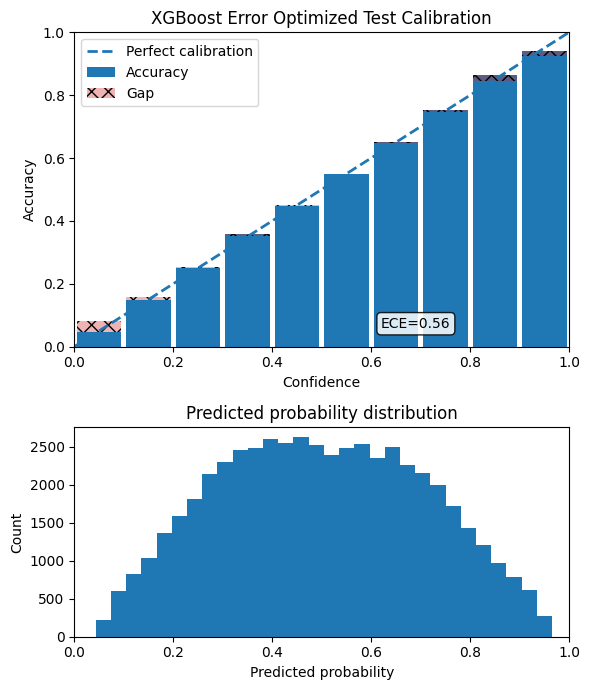

In [7]:

best_params2 = study2.best_params
oof_probs2 = ts_cv_oof_probs(best_params2, n_splits=10)

m = ~np.isnan(oof_probs2)

oof_logloss = log_loss(y[m], oof_probs2[m])
oof_acc = accuracy_score(y[m], (oof_probs2[m] >= 0.5).astype(int))
oof_error_rate = 1.0 - oof_acc
ece = expected_calibration_error(y, oof_probs2, n_bins=10)

print(f"OOF log loss: {oof_logloss}")
print(f"OOF accuracy: {oof_acc}")
print(f"OOF error rate: {oof_error_rate}")
print(f"OOF ECE: {ece}")
print(f"OOF ECE (% points): {ece*100}")

figureb = reliability_diagram(y, oof_probs2, n_bins=10, title="XGBoost Error Optimized Test Calibration")